<a href="https://colab.research.google.com/github/zwimpee/cursivetransformer/blob/main/cursivetransformer_mech_interp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setup

!pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python
!pip install transformer_lens
!pip install gradio
!pip install wandb
!pip install einops
!pip install matplotlib
!pip install datasets

# Clone the cursivetransformer repository and install its requirements
!rm -rf cursivetransformer && git clone https://github.com/zwimpee/cursivetransformer.git
!pip install -r cursivetransformer/requirements.txt

  Cloning https://github.com/callummcdougall/CircuitsVis.git to /tmp/pip-req-build-0pn53ss9
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/CircuitsVis.git /tmp/pip-req-build-0pn53ss9
  Resolved https://github.com/callummcdougall/CircuitsVis.git to commit 1e6129d08cae7af9242d9ab5d3ed322dd44b4dd3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for circuitsvis: filename=circuitsvis-0.0.0-py3-none-any.whl size=6172334 sha256=59415c32edc93016c6c42f3b4833706a3be43b700e7573be5495cc7c0ec5f306
  Stored in directory: /tmp/pip-ephem-wheel-cache-sz4yyq8o/wheels/86/be/ad/78078aba9344d200aad61b63d35cdaecdec160212f039eed74
Successfully built circuitsvis
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib_metadata 8.4.0
    Uninstalling importlib_metadata-8.4.0:
      Successfully uninstalled importlib_metadata-8.4.0
ERROR: 

In [2]:
import os
import sys; sys.path.append('/content/cursivetransformer');
import copy
import types
from typing import List, Callable, Dict, Optional, Union
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import einops
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import circuitsvis as cv

from IPython.display import display
from jaxtyping import Float, Int

from cursivetransformer.model import get_all_args, get_checkpoint, get_latest_checkpoint_artifact
from cursivetransformer.data import create_datasets, offsets_to_strokes, strokes_to_offsets
from cursivetransformer.sample import generate, generate_n_words, plot_strokes
from cursivetransformer.mech_interp import (
    HookedCursiveTransformer,
    HookedCursiveTransformerConfig,
    convert_cursivetransformer_model_config,
    visualize_attention
)

import transformer_lens.utils as utils
from transformer_lens.hook_points import HookPoint
from transformer_lens import ActivationCache

torch.set_grad_enabled(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
args = get_all_args(False)
args.sample_only = True
args.load_from_run_id = '6le6tujz'
args.wandb_entity = 'sam-greydanus'
args.dataset_name = 'bigbank'
args.wandb_run_name = 'cursivetransformer_dictionary_learning'

torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

train_dataset, test_dataset = create_datasets(args)

args.block_size = train_dataset.get_stroke_seq_length()
args.context_block_size = train_dataset.get_text_seq_length()
args.vocab_size = train_dataset.get_vocab_size()
args.context_vocab_size = train_dataset.get_char_vocab_size()

Trying to load dataset file from /content/cursivetransformer/data/bigbank.json.zip
Succeeded in loading the bigbank dataset; contains 1900 items.
For a dataset of 1805 examples we can generate 440811596555 combinations of 4 examples.
Generating 497000 4-word examples.
For a dataset of 95 examples we can generate 3183545 combinations of 4 examples.
Generating 3000 4-word examples.
Number of examples in the train dataset: 497000
Number of examples in the test dataset: 3000
Max token sequence length: 1000
Number of unique characters in the ascii vocabulary: 71
Ascii vocabulary:
	" enaitoshrdx.vpukbgfcymzw1lqj804I92637OTAS5N)EHR"'(BCQLMWYU,ZF!DXV?KPGJ"
Split up the dataset into 497000 training examples and 3000 test examples


In [4]:
cfg = convert_cursivetransformer_model_config(args)
model = HookedCursiveTransformer.from_pretrained("cursivetransformer", cfg)

Loading pretrained model cursivetransformer
Finding latest checkpoint for W&B run id 6le6tujz
  model:best_checkpoint:v70
  model:best_checkpoint:v71
  model:best_checkpoint:v72
  model:best_checkpoint:v73
  model:best_checkpoint:v74
  model:best_checkpoint:v75
  model:best_checkpoint:v76
  model:best_checkpoint:v77
  model:best_checkpoint:v78
  model:best_checkpoint:v79
  model:best_checkpoint:v80
  model:best_checkpoint:v81
  model:best_checkpoint:v82
  model:best_checkpoint:v83
  model:best_checkpoint:v84
  model:best_checkpoint:v85
  model:best_checkpoint:v86
  model:best_checkpoint:v87
  model:best_checkpoint:v88
  model:best_checkpoint:v89
  wandb-history:run-6le6tujz-history:v4
Selected:  model:best_checkpoint:v89


wandb:   1 of 1 files downloaded.  


Successfully loaded pretrained model cursivetransformer


# Induction Circuit Investigation and Analysis





In [6]:
test_dataset.feature_sizes

[302, 151]

In [8]:
test_dataset.cumulative_sizes

array([  0, 302, 453])

Performance on the first half: -6.366
Performance on the second half: -6.311


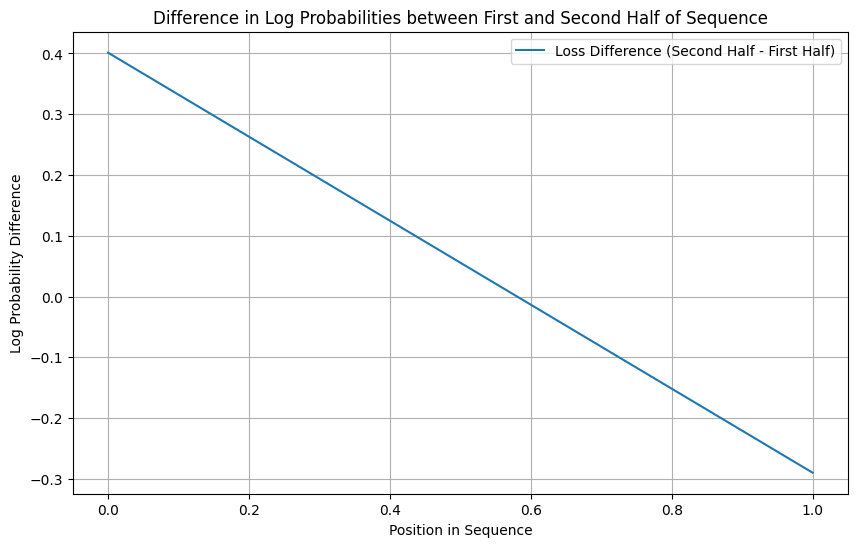

In [18]:
def generate_repeated_tokens(model: HookedCursiveTransformer, seq_len: int, n_repeats: int, batch: int = 1) -> Int[torch.Tensor, "batch full_seq_len"]:
    '''
    Generates a sequence of repeated random tokens alternating between theta and r tokens

    Outputs are:
        rep_tokens: [batch, n_repeats*seq_len]
    '''
    theta_token_indices = torch.tensor(range(test_dataset.feature_sizes[1], test_dataset.cumulative_sizes[2]))
    r_token_indices = torch.tensor(range(test_dataset.cumulative_sizes[0], test_dataset.cumulative_sizes[1]))

    rep_tokens_half = torch.zeros((batch, seq_len), dtype=torch.int64)
    rep_tokens_half[:, ::2] = theta_token_indices[torch.randint(0, len(theta_token_indices), (batch, seq_len // 2 + seq_len % 2))]
    rep_tokens_half[:, 1::2] = r_token_indices[torch.randint(0, len(r_token_indices), (batch, seq_len // 2))]

    rep_tokens = torch.cat([rep_tokens_half, rep_tokens_half], dim=-1)
    return rep_tokens

# - [ ] TODO: Align the ascii context tokens to repeat with the stroke tokens
def generate_random_ascii_context(model: HookedCursiveTransformer, seq_len: int, n_repeats: int, batch: int = 1) -> Int[torch.Tensor, "batch seq_len"]:
    '''
    Generates a sequence of random ASCII context tokens

    Outputs are:
        context_tokens: [batch, seq_len]
    '''
    context_tokens = torch.randint(0, model.cfg.context_vocab_size, (batch, seq_len), dtype=torch.int64)
    return context_tokens


def run_and_cache_model_repeated_tokens(model: HookedCursiveTransformer, stroke_seq_len: int, ascii_seq_len: int, n_repeats: int, batch: int = 1) -> tuple[torch.Tensor, torch.Tensor, ActivationCache]:
    '''
    Generates a sequence of repeated random tokens and random ASCII context, and runs the model on it, returning (tokens, logits, cache)

    Should use the `generate_repeated_tokens` and `generate_random_ascii_context` functions above

    Outputs are:
        rep_tokens: [batch, 1+2*seq_len]
        rep_logits: [batch, 1+2*seq_len, d_vocab]
        rep_cache: The cache of the model run on rep_tokens
    '''
    rep_tokens = generate_repeated_tokens(model, stroke_seq_len, n_repeats, batch)
    context_tokens = generate_random_ascii_context(model, ascii_seq_len, n_repeats, batch)
    rep_logits, rep_cache = model.run_with_cache(rep_tokens, context_tokens, rep_tokens[1:])
    return rep_tokens, rep_logits, rep_cache

def get_log_probs(logits: torch.Tensor, tokens: torch.Tensor) -> torch.Tensor:
    '''
    Computes the log probabilities of the true tokens given the model logits.

    Outputs are:
        log_probs: [batch, seq_len]
    '''
    log_probs = F.log_softmax(logits, dim=-1)
    token_log_probs = log_probs.gather(-1, tokens.unsqueeze(-1)).squeeze(-1)
    return token_log_probs

def plot_loss_difference(log_probs: torch.Tensor, seq_len: int):
    '''
    Plots the difference in log probabilities between the first and second half of the repeated sequence.

    Outputs are:
        A plot displaying the loss difference by token position.
    '''
    first_half_loss = log_probs[:seq_len].cpu().numpy()
    second_half_loss = log_probs[seq_len:].cpu().numpy()
    difference = second_half_loss - first_half_loss
    positions = np.arange(seq_len)
    plt.figure(figsize=(10, 6))
    plt.plot(positions, difference, label="Loss Difference (Second Half - First Half)")
    plt.xlabel("Position in Sequence")
    plt.ylabel("Log Probability Difference")
    plt.title("Difference in Log Probabilities between First and Second Half of Sequence")
    plt.legend()
    plt.grid(True)
    plt.show()

stroke_seq_len = 2
ascii_seq_len = 1
n_repeats = 1
batch = 1
(rep_tokens, rep_logits, rep_cache) = run_and_cache_model_repeated_tokens(model, stroke_seq_len, ascii_seq_len, n_repeats, batch)
log_probs = get_log_probs(rep_logits, rep_tokens).squeeze()

print(f"Performance on the first half: {log_probs[:stroke_seq_len].mean():.3f}")
print(f"Performance on the second half: {log_probs[stroke_seq_len:].mean():.3f}")

plot_loss_difference(log_probs, stroke_seq_len)

In [ ]:
# Store induction scores
# induction_score_store = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device=model.cfg.device)

# def induction_score_hook(pattern: torch.Tensor, hook: HookPoint):
#     induction_stripe = pattern.diagonal(dim1=-2, dim2=-1, offset=1 - stroke_sequence.shape[0])
#     induction_score = einops.reduce(induction_stripe, "batch head_index position -> head_index", "mean")
#     induction_score_store[hook.layer(), :] = induction_score

# # Updated hook filter for both self-attention and cross-attention patterns
# pattern_hook_names_filter = lambda name: name.endswith("attn.hook_pattern") or name.endswith("cross_attn.hook_pattern")

# # Run with hooks to collect induction scores
# _ = model.run_with_hooks(
#     repeated_tokens,
#     repeated_context,
#     fwd_hooks=[(
#         pattern_hook_names_filter,
#         induction_score_hook
#     )]
# )

# # Visualize induction score by head
# px.imshow(induction_score_store.detach().cpu(), labels={"x": "Head", "y": "Layer"}, title="Induction Score by Head").show()

# # Visualization of Attention Pattern
# def visualize_pattern_hook(pattern: torch.Tensor, hook: HookPoint):
#     display(
#         cv.attention.attention_patterns(
#             tokens=repeated_tokens,
#             attention=pattern[0, induction_head_index, :, :][None, :, :] # Add a dummy axis, as CircuitsVis expects 3D patterns.
#         )
#     )

# induction_head_layer = 3
# induction_head_index = 1
# model.run_with_hooks(
#     repeated_tokens,
#     repeated_context,
#     fwd_hooks=[(
#         'blocks.{}.cross_attn.hook_pattern'.format(induction_head_layer),
#         visualize_pattern_hook
#     )]
# )

# # Activation Patching

# # Activation Patching - Updated for Cross-Attention
# def activation_patching(
#     model: HookedCursiveTransformer,
#     x_clean: torch.Tensor,
#     c_clean: torch.Tensor,
#     x_corrupted: torch.Tensor,
#     c_corrupted: torch.Tensor,
#     patching_nodes: List[str],
#     patch_positions: Optional[torch.Tensor] = None,
# ):
#     _, cache_corrupted = model.run_with_cache(x_corrupted, c_corrupted, return_type="both")

#     def patching_hook(act, hook):
#         act_corrupted = cache_corrupted[hook.name]
#         if patch_positions is not None:
#             act[:, patch_positions, :] = act_corrupted[:, patch_positions, :]
#         else:
#             act[:] = act_corrupted
#         return act

#     hooks = [(node, patching_hook) for node in patching_nodes]
#     logits_patched = model.run_with_hooks(x_clean, c_clean, fwd_hooks=hooks, return_type="logits")
#     return logits_patched

# # Example Activation Patching
# x_clean = stroke_sequence.unsqueeze(0)
# c_clean = ascii_sequence.unsqueeze(0)

# x_corrupted = x_clean.clone()
# x_corrupted = (x_corrupted + 1) % model.cfg.d_vocab
# c_corrupted = c_clean.clone()

# patching_nodes = ['blocks.0.cross_attn.hook_result']
# logits_patched = activation_patching(
#     model,
#     x_clean,
#     c_clean,
#     x_corrupted,
#     c_corrupted,
#     patching_nodes,
# )

# # Get predictions from patched logits
# predictions_patched = logits_patched.argmax(dim=-1)

# # Run the clean input without patches
# logits_clean = model(x_clean, c_clean)
# predictions_clean = logits_clean.argmax(dim=-1)

# # Run the corrupted input without patches
# logits_corrupted = model(x_corrupted, c_corrupted)
# predictions_corrupted = logits_corrupted.argmax(dim=-1)

# # Compare predictions
# print("Clean Predictions:", predictions_clean)
# print("Corrupted Predictions:", predictions_corrupted)
# print("Patched Predictions:", predictions_patched)

# # Visualize the strokes if applicable
# _ = plot_strokes(offsets_to_strokes(test_dataset.decode_stroke(stroke_sequence)), test_dataset.decode_text(ascii_sequence))
# _ = plot_strokes(offsets_to_strokes(test_dataset.decode_stroke(x_corrupted[0])), test_dataset.decode_text(c_corrupted[0]))